In [79]:
! pip install ydata-profiling

In [80]:
! pip install surprise

<a class="anchor" id="chapitre1"></a><hr><center><b><h1><font color=green>1/ Gestion des données</font></h1></b></center><hr>

<a class="anchor" id="partie_1_1"></a><b><h2><font color=blue>1.1/ Import des bibliothèques</font></h2></b>

In [81]:
from __future__ import print_function

# Manipulation de données
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Utilaires
import re
import os
import glob

#from collections import Counter, namedtuple
#import logging
import time
import pickle
import shutil
from tqdm import tqdm

# My functions
#import Guitarian_Guillaume_0_myFunctions_012023 as mfs 


#Cosin similarity
from sklearn.metrics.pairwise import cosine_similarity

# Normalisation
from sklearn.preprocessing import MinMaxScaler

#Surprise
from surprise import SVD, accuracy
from surprise import Dataset
from surprise import Reader
from surprise.builtin_datasets import BUILTIN_DATASETS, download_builtin_dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.random_pred import NormalPredictor


from collections import defaultdict


%matplotlib inline
sns.set() 

<a class="anchor" id="partie_1_2"></a><b><h2><font color=purple>1.2/ Gestion des données</font></h2></b>

### Nous allons utiliser le jeux de données décrit ici : <a href="https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom/">Globo.com</a>

<a class="anchor" id="partie_1_2_1"></a><b><h3><font color=blue>1.2.1/ Récupération des données</font></h3></b>

In [82]:
import os
import zipfile
import requests

class FileDownloader:
    def __init__(self, remote_url, data_path):
        self.remote_url = remote_url
        self.data_path = data_path

    def download_and_unzip_file(self, zip_file_url, target_dir):
        """
        Télécharge et décompresse un fichier zip à partir de l'URL distante dans un répertoire cible.

        Args:
            zip_file_url (str): URL du fichier zip à télécharger et décompresser.
            target_dir (str): Chemin du répertoire cible pour la décompression.
        """
        # Télécharger le fichier zip à partir de l'URL distante
        print(f"Téléchargement de {zip_file_url} ...")
        response = requests.get(zip_file_url)
        zip_file_name = os.path.basename(zip_file_url)
        zip_file_path = os.path.join(self.data_path, zip_file_name)

        # Enregistrer le fichier zip sur le disque
        with open(zip_file_path, 'wb') as file:
            file.write(response.content)

        # Décompresser le fichier zip dans le répertoire cible
        print(f"Décompression de {zip_file_name} ...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

        # Supprimer le fichier zip téléchargé après la décompression
        os.remove(zip_file_path)

        print(f"Fichier {zip_file_name} téléchargé et décompressé dans {target_dir}.")

    def verify_directory_contents(self, dir_path):
        """
        Vérifie le contenu du répertoire.

        Args:
            dir_path (str): Chemin du répertoire à vérifier.
        """
        print(f"Contenu du répertoire {dir_path} :")
        print(os.listdir(dir_path))


In [83]:
remote_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip"
data_path = '/kaggle/working/'
target_dir = data_path

file_downloader = FileDownloader(remote_url, data_path)

# Télécharger et décompresser le fichier zip
file_downloader.download_and_unzip_file(remote_url, target_dir)

# Vérifier le contenu du répertoire cible
file_downloader.verify_directory_contents(target_dir)


Téléchargement de https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip ...
Décompression de news-portal-user-interactions-by-globocom.zip ...
Fichier news-portal-user-interactions-by-globocom.zip téléchargé et décompressé dans /kaggle/working/.
Contenu du répertoire /kaggle/working/ :
['content_embeddings.npy', 'all_click.csv', 'clicks.zip', '.virtual_documents', '__notebook_source__.ipynb', 'clicks_sample.csv', 'articles_embeddings.pickle', 'ratings.csv', 'articles_metadata.csv']


In [84]:


# Chemin du répertoire contenant les fichiers CSV
csv_folder = '/kaggle/working/'

# Liste des fichiers CSV dans le répertoire
csv_files = [f for f in os.listdir(csv_folder) if f.startswith('clicks') and f.endswith('.csv')]

# Liste des DataFrames à concaténer
dfs = [pd.read_csv(os.path.join(csv_folder, f)) for f in csv_files]

# Concaténation des DataFrames
all_click = pd.concat(dfs, ignore_index=True)

# Afficher le dataframe combiné
print(all_click.head())


all_click.to_csv('/kaggle/working/all_click.csv', index=False)
del all_click

   user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   
3    1506827047951                  4                  1        17   
4    1506827090575                  4                  1        17   

   click_country  click_region  click_referrer_type  
0              1            20                    

#ACP de l'embeding des articles 'fichiers binaires de vecteurs)

In [85]:
# Chargement des vecteurs d'embedding des articles
with open("/kaggle/working/articles_embeddings.pickle", 'rb') as f:
    article_embeddings = pickle.load(f)


In [86]:
article_embeddings

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [87]:
article_embeddings.shape

(364047, 250)

In [88]:
# Assuming article_embeddings is your NumPy array
df = pd.DataFrame(article_embeddings)

In [89]:
df

0         1         2         3         4         5         6    \
0      -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365 -0.335148   
1      -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297 -0.715657   
2      -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535 -0.730477   
3      -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745 -0.825593   
4      -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913 -0.568816   
...          ...       ...       ...       ...       ...       ...       ...   
364042 -0.055038 -0.962136  0.869436 -0.071523 -0.725294  0.434320  0.198312   
364043 -0.136932 -0.995471  0.991298  0.031871 -0.915622 -0.658517  0.633090   
364044 -0.251390 -0.976243  0.586097  0.643631 -0.663359 -0.093480  0.691553   
364045  0.224342 -0.923288 -0.381742  0.687890 -0.773911 -0.103629 -0.406486   
364046 -0.257134 -0.994631  0.983792 -0.190975 -0.953720 -0.893823  0.708974   

             7         8         9    ...       240       241       242  \
0      -0.559561 -0.500603  0.165183  ...  0.321248  0.313999  0.636412   
1      -0.897996 -0.359747  0.398246  ... -0.487843  0.823124  0.412688   
2      -0.066126 -0.754899 -0.242004  ...  0.454756  0.473184  0.377866   
3      -0.710591 -0.040099 -0.110514  ...  0.271535  0.036040  0.480029   
4       0.341194 -0.600554 -0.125644  ...  0.238286  0.809268  0.427521   
...          ...       ...       ...  ...       ...       ...       ...   
364042 -0.581154  0.702346 -0.124813  ... -0.410549  0.564252 -0.463959   
364043 -0.564356  0.676551 -0.446068  ... -0.681986 -0.574185 -0.536908   
364044 -0.588281  0.902999  0.124571  ... -0.162220 -0.242030 -0.476131   
364045  0.246004  0.255191 -0.329587  ... -0.422999  0.390324  0.655911   
364046 -0.557027  0.846842 -0.118519  ... -0.490481 -0.689666 -0.661846   

             243       244       245       246       247       248       249  
0       0.169179  0.540524 -0.813182  0.286870 -0.231686  0.597416  0.409623  
1      -0.338654  0.320787  0.588643 -0.594137  0.182828  0.397090 -0.834364  
2      -0.863887 -0.383365  0.137721 -0.810877 -0.447580  0.805932 -0.285284  
3      -0.763173  0.022627  0.565165 -0.910286 -0.537838  0.243541 -0.885329  
4      -0.615932 -0.503697  0.614450 -0.917760 -0.424061  0.185484 -0.580292  
...          ...       ...       ...       ...       ...       ...       ...  
364042  0.167907 -0.480068  0.652090  0.380880  0.433195 -0.662455 -0.222850  
364043  0.688934  0.528204  0.162435  0.940364  0.989298 -0.761595 -0.414652  
364044  0.352132 -0.311279  0.460574 -0.653077 -0.143725  0.068093 -0.705010  
364045 -0.646753 -0.174031  0.698037 -0.317102  0.687132 -0.531512  0.010726  
364046  0.490945  0.736525  0.667668  0.902130  0.983873 -0.838183 -0.179283  

[364047 rows x 250 columns]

In [90]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,15))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,15))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [91]:
from sklearn.decomposition import PCA

In [92]:

#pourcentage d'information a garder
pinf = 85

Nombre de composantes pour garder 85 % de l'information : 33


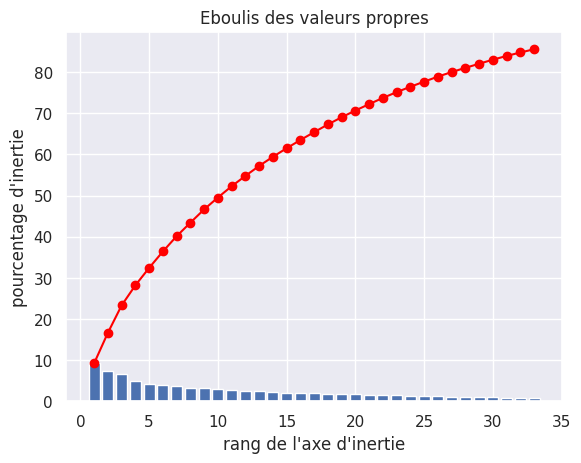

In [93]:

# choix du nombre de composantes à calculer
n_comp = article_embeddings.shape[1]



# selection des colonnes à prendre en compte dans l'ACP
data_pca = df

# préparation des données pour l'ACP
X = data_pca
names = data_pca.columns # ou data.index pour avoir les intitulés
features = data_pca.columns

pca = PCA(svd_solver='full')
pca.fit(X)

explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_needed = np.argmax(explained_variance_ratio_cumsum >=pinf/100) + 1

print("Nombre de composantes pour garder 85 % de l'information :", n_components_needed)

# Assuming n_comp is the desired number of components
pca = PCA(n_components=n_components_needed)
pca.fit(X)

# Eboulis des valeurs propres
display_scree_plot(pca)




plt.show()

In [94]:
pca = PCA(n_components=n_components_needed, svd_solver='full')
pca.fit(X)
PCA(n_components=n_components_needed, svd_solver='full')
print(pca.explained_variance_ratio_)
# Calcul du total d'information
total_information = np.sum(pca.explained_variance_ratio_)

# Affichage du total d'information
print("Total d'information expliquée : {:.2%}".format(total_information))

[0.09248691 0.07410159 0.0665301  0.04882729 0.04229693 0.0398789
 0.0371496  0.0328388  0.0322826  0.02882203 0.02742617 0.02508953
 0.02424455 0.02221376 0.02075828 0.02004813 0.01905768 0.01874834
 0.01749015 0.01640778 0.01549593 0.01512781 0.01400184 0.01307736
 0.01241082 0.01220324 0.01112803 0.01023836 0.00998776 0.00988174
 0.00909359 0.00841637 0.00790775]
Total d'information expliquée : 85.57%


Total d'information expliquée : 98.01%

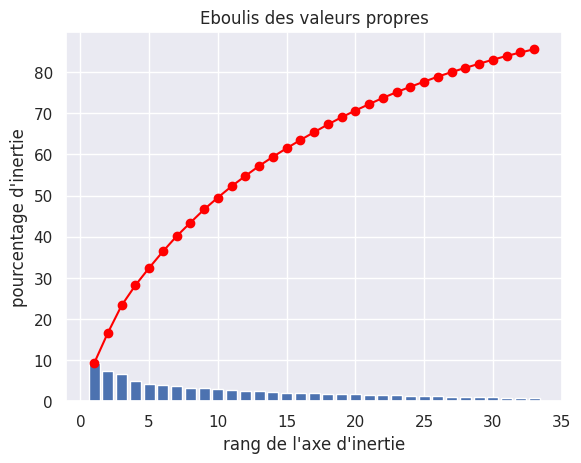

In [95]:

# Assuming n_comp is the desired number of components
pca = PCA(n_components_needed)
pca.fit(X)

# Eboulis des valeurs propres
display_scree_plot(pca)

               

plt.show()

In [96]:
pca = PCA(n_components_needed)
pca.fit(X)  # X_original représente les données d'origine avec 250 caractéristiques


PCA(n_components=33)

In [97]:
# Réduction des données à n dimensions
article_embeddings = pca.transform(X)

In [98]:
article_embeddings.shape

(364047, 33)

In [99]:


# Vérification du type
print(type(article_embeddings))

<class 'numpy.ndarray'>


In [100]:
# Demander à l'utilisateur combien de lignes il souhaite charger
num_rows = int(input("Combien de lignes voulez-vous charger ? "))

# Charger les premières lignes depuis le fichier CSV
all_click = pd.read_csv("/kaggle/working/all_click.csv", nrows=num_rows)

# Afficher le DataFrame chargé
print(all_click.head())

Combien de lignes voulez-vous charger ?  100000


   user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   
1    1506826858020                  4                  3        20   
2    1506827017951                  4                  1        17   
3    1506827047951                  4                  1        17   
4    1506827090575                  4                  1        17   

   click_country  click_region  click_referrer_type  
0              1            20                    

In [101]:
all_click.shape

(1883, 12)

<a class="anchor" id="partie_1_3"></a><b><h2><font color=orange>1.2/ Analyse des donnée avec pandas_profiling</font></h2></b>

In [102]:
all_click.columns

Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')

In [103]:
import ydata_profiling

from ydata_profiling.config import Settings

from ydata_profiling import ProfileReport


config = Settings(title='Pandas Profiling Report', html={'style':{'full_width':True}})


profile = ProfileReport(all_click,  explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [104]:

 # Charger un dataframe
articles_metadata = pd.read_csv('/kaggle/working/articles_metadata.csv')

# Générer un rapport de profil
profile1 = ProfileReport(articles_metadata,  explorative=True)


profile1.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [105]:
articles_metadata.columns

Index(['article_id', 'category_id', 'created_at_ts', 'publisher_id',
       'words_count'],
      dtype='object')

<a class="anchor" id="chapitre2"></a><hr><center><b><h1><font color=orange>2/ Les différentes approches</font></h1></b></center><hr>[![retour.png](attachment:retour.png)](#sommaire)

<a class="anchor" id="partie_2_1"></a><b><h2><font color=purple>2.1/ Content Based Filtering</font></h2></b>




<a class="anchor" id="partie_2_1_1"></a><b><h3><font color=blue>2.1.1/ Préparation des données</font></h3></b>

In [106]:


# Chargement des données

# Chargement des vecteurs d'embedding des articles
with open('/kaggle/working/articles_embeddings.pickle', 'rb') as f:
    article_embeddings = pickle.load(f)

# Suppression des articles non lus
articles_lus = all_click['click_article_id'].unique()
articles_metadata = articles_metadata[articles_metadata['article_id'].isin(articles_lus)]
article_embeddings = article_embeddings[articles_metadata.index]

# Construction de la matrice des embeddings
embedding_matrix = np.vstack(article_embeddings)

# Ajout des variables du DataFrame des métadonnées aux données d'embedding
metadata_matrix = articles_metadata[['category_id', 'publisher_id', 'words_count']].to_numpy()
content_matrix = np.hstack((metadata_matrix, embedding_matrix))

# Enregistrement de la matrice des embeddings
np.save("content_embeddings.npy", content_matrix)


In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Chargement des données et des embeddings

content_matrix = np.load("content_embeddings.npy")

# Construction de la matrice de similarité
similarity_matrix = cosine_similarity(content_matrix)

# Exemple de recommandation pour l'article avec :
for bcl in range(1,100,9):
        article_id = bcl
        similar_articles_indices = np.argsort(similarity_matrix[article_id])[::-1][1:11]
        similar_articles = articles_metadata.iloc[similar_articles_indices]['article_id'].tolist()
        print(f"Recommandations pour l'article {article_id} :")
        print(similar_articles)


Recommandations pour l'article 1 :
[4243, 2137, 4658, 16833, 15552, 16731, 16129, 16609, 19839, 7947]
Recommandations pour l'article 10 :
[10955, 15552, 16731, 16833, 15079, 14197, 16129, 16609, 13337, 13540]
Recommandations pour l'article 19 :
[32608, 30169, 30970, 33935, 31862, 32764, 36855, 42249, 42210, 14617]
Recommandations pour l'article 28 :
[42210, 40509, 36292, 207122, 42249, 36855, 207129, 33935, 29882, 32608]
Recommandations pour l'article 37 :
[76537, 76510, 48478, 69162, 44488, 207129, 69341, 67846, 59782, 48915]
Recommandations pour l'article 46 :
[92042, 158964, 66326, 83472, 84238, 66457, 48337, 83576, 84467, 68866]
Recommandations pour l'article 55 :
[76537, 69162, 48973, 48478, 69341, 44488, 67846, 207129, 59782, 48915]
Recommandations pour l'article 64 :
[159715, 123750, 132840, 338132, 168701, 157132, 144938, 157077, 217717, 161866]
Recommandations pour l'article 73 :
[97480, 106886, 119592, 157541, 160474, 157485, 202436, 182394, 154812, 73413]
Recommandations pou

Collaborative Filtering avec la librairie Surprise

In [108]:
# Charger le dataframe des sessions de lecture
df = all_click

# Filtrer les colonnes 'user_id' et 'click_article_id'
ratings = df[['user_id', 'click_article_id']]

# Ajouter une colonne 'rating'
ratings['rating'] = 1

# Supprimer les doublons
ratings.drop_duplicates(inplace=True)

# Sauvegarder le dataframe de notations en CSV
ratings.to_csv('ratings.csv', index=False)

/tmp/ipykernel_34/3455038602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating'] = 1
/tmp/ipykernel_34/3455038602.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings.drop_duplicates(inplace=True)


In [109]:
import pandas as pd
from surprise import Dataset, Reader

# Charger le fichier CSV en utilisant pandas
df = pd.read_csv('ratings.csv')

# Créer l'objet Reader avec l'échelle de notation spécifiée
reader = Reader(rating_scale=(0, 5))

# Charger les données à partir du DataFrame en utilisant l'objet Reader
data = Dataset.load_from_df(df[['user_id', 'click_article_id', 'rating']], reader)





In [110]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=.25)


métrique 
Le rapport de précision calculé mesure la proportion moyenne d'articles prédits qui ont été réellement lus par les utilisateurs de test.

In [117]:
import random
from collections import defaultdict
from surprise import accuracy, Dataset, KNNBaseline, NMF, SVD, SlopeOne, CoClustering
from surprise.model_selection import train_test_split

# Fixer la graine aléatoire
random.seed(42)

# Diviser les données en ensemble de train et test
trainset, testset = train_test_split(data, test_size=0.25)

# Liste des modèles à évaluer
models = [KNNBaseline(sim_options={'name': 'cosine', 'user_based': False}),
          SVD(),
          SlopeOne(),
          CoClustering(),
          NMF()]

# Evaluer chaque modèle
for model in models:
    # Entrainement sur les données d'entrainement
    model.fit(trainset)

    # Prédiction des notes pour les données de test
    predictions = model.test(testset)

    # Obtention des articles prédits pour chaque utilisateur de test
    n = 4 # Nombre d'articles à recommander
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]

    # Obtention des articles réellement lus par chaque utilisateur de test
    ground_truth = defaultdict(list)
    for uid, iid, true_r in testset:
        ground_truth[uid].append(iid)

    # Calcul du rapport de précision
    precision = 0
    for uid in top_n.keys():
        prec = len(set(top_n[uid]) & set(ground_truth[uid])) / float(n)
        precision += prec
    precision /= len(top_n)

    # Affichage du rapport de précision avec 5 décimales
    print(f"Modèle : {model.__class__.__name__}, rapport de précision : {precision:.5f}")


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Modèle : KNNBaseline, rapport de précision : 0.32438
Modèle : SVD, rapport de précision : 0.32438
Modèle : SlopeOne, rapport de précision : 0.32438
Modèle : CoClustering, rapport de précision : 0.32438
Modèle : NMF, rapport de précision : 0.32438


In [113]:
from collections import defaultdict
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import train_test_split

# Diviser les données en ensemble de train et test
trainset, testset = train_test_split(data, test_size=0.95)

# Instanciation du modèle
model = SVD()

# Entrainement sur les données d'entrainement
model.fit(trainset)

# Prédiction des notes pour les données de test
predictions = model.test(testset)

# Obtention des articles prédits pour chaque utilisateur de test
n = 10  # Nombre d'articles à recommander
top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = [iid for (iid, _) in user_ratings[:n]]

# Obtention des articles réellement lus par chaque utilisateur de test à partir des 5% restants
ground_truth = defaultdict(list)
for uid, iid, true_r in testset:
    ground_truth[uid].append(iid)

# Calcul du rapport de précision avec les nouvelles variables à partir des 5% restants
precision = 0
for uid in top_n.keys():
    prec = len(set(top_n[uid]) & set(ground_truth[uid])) / float(n)
    precision += prec
precision /= len(top_n)
print("Rapport de précision : ", precision)


Rapport de précision :  0.25056657223795836
